In [1]:
import warnings
warnings.filterwarnings('ignore')


In [8]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import models, layers
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import h5py

In [3]:
import numpy as np

data = np.load('PreprocessData/preprocessed_birds.npz')
X_train = data['X_train']
y_train = data['y_train']
X_val = data['X_val']
y_val = data['y_val']
X_test = data['X_test']
y_test = data['y_test']

num_classes = len(np.unique(y_train))
species_labels = [
    'amecro', 'amerob', 'bewwre', 'bkcchi', 'daejun', 'houfin',
    'houspa', 'norfli', 'rewbla', 'sonspa', 'spotow', 'whcspa'
]


In [4]:

X_train_cnn = X_train[..., np.newaxis]
X_val_cnn = X_val[..., np.newaxis]
X_test_cnn = X_test[..., np.newaxis]

# One-hot encode labels
y_train_cat = to_categorical(y_train, num_classes)
y_val_cat = to_categorical(y_val, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

In [5]:

def build_multiclass_cnn(input_shape, num_classes):
    model = models.Sequential([
        
        layers.Input(shape=input_shape),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.4),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')  # softmax for multi-class
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_multiclass_cnn(X_train.shape[1:], num_classes)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 517, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 258, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 258, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 258, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 129, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 129, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 129, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 129, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,628 (436.05 KB)

 Trainable params: 111,180 (434.30 KB)

 Non-trainable params: 448 (1.75 KB)

In [9]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    X_train_cnn, y_train_cat,
    epochs=20,
    batch_size=32,
    validation_data=(X_val_cnn, y_val_cat),
    callbacks=[early_stop],
    class_weight=class_weight_dict,
    
)

     

Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.9942 - loss: 0.0366 - val_accuracy: 0.2683 - val_loss: 3.5766
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.9983 - loss: 0.0278 - val_accuracy: 0.4675 - val_loss: 2.5741
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 1.0000 - loss: 0.0189 - val_accuracy: 0.4878 - val_loss: 2.3528
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 1.0000 - loss: 0.0134 - val_accuracy: 0.5041 - val_loss: 2.1941
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 1.0000 - loss: 0.0093 - val_accuracy: 0.5894 - val_loss: 1.2909
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 1.0000 - loss: 0.0115 - val_accuracy: 0.5935 - val_loss: 0.8084
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 1.0000 - loss: 0.0091 - val_accuracy: 0.7561 - val_loss: 0.4633
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 1.0000 - loss: 0.0088 - val_accuracy: 0.8577 - val_loss:

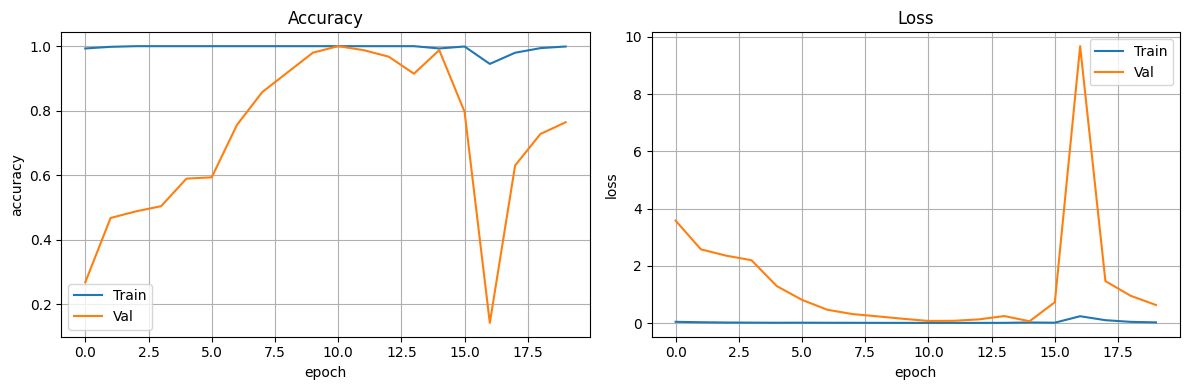

In [10]:


def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Train")
    plt.plot(history.history["val_accuracy"], label="Val")
    plt.grid()
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.title("Accuracy")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Train")
    plt.plot(history.history["val_loss"], label="Val")
    plt.grid()
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.title("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_history(history)


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 204ms/step
Classification Report:
              precision    recall  f1-score   support

      amecro       1.00      0.56      0.72        25
      amerob       1.00      0.42      0.59        26
      bewwre       1.00      0.04      0.07        26
      bkcchi       0.96      1.00      0.98        26
      daejun       1.00      0.62      0.76        26
      houfin       0.00      0.00      0.00        26
      houspa       1.00      1.00      1.00        26
      norfli       0.72      1.00      0.84        26
      rewbla       1.00      0.96      0.98        25
      sonspa       1.00      1.00      1.00        25
      spotow       0.49      1.00      0.66        25
      whcspa       0.34      1.00      0.50        26

    accuracy                           0.71       308
   macro avg       0.79      0.72      0.68       308
weighted avg       0.79      0.71      0.67       308



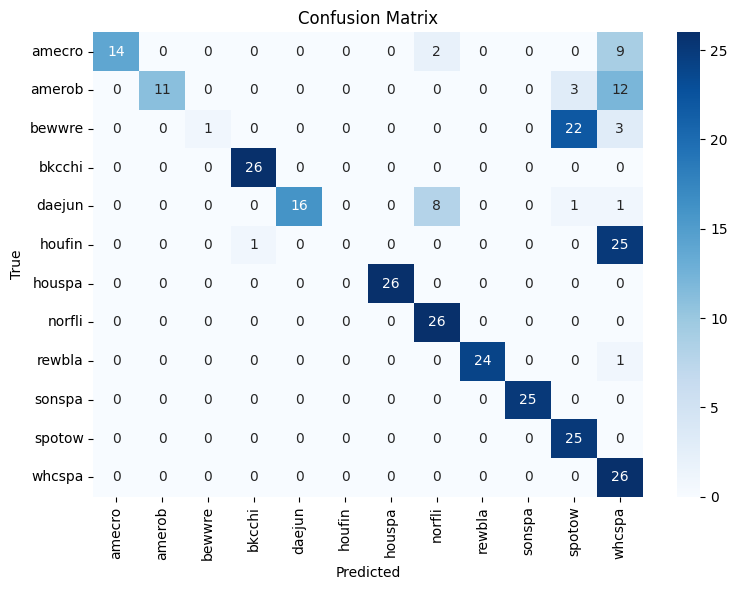

In [14]:
y_pred = np.argmax(model.predict(X_test_cnn), axis=1)

# Report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=species_labels))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=species_labels, yticklabels=species_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


In [15]:
# Save model as a .h5 file
model.save("results/model/my_multiclass_cnn_model.h5")
